In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# NVTabular with TensorFlow Feature Columns
We'll be basing this example off of [TensorFlow's structured data tutorial](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/feature_columns.ipynb), but we'll show how to move all of its functionality onto the GPU, and even make it robust to larger and more complex use cases (where GPU acceleration will be more pronounced). Let's begin by starting the same way: doing our imports and downloading the data.

## VERY IMPORTANT THING TO NOTE
Using NVTabular for TensorFlow data loading requires saving some GPU memory for use by the libraries NVT wraps around, namely CuDF. This is slightly non-trivial, since TensorFlow's default behavior is to grab all of the GPU's memory for itself as soon as its context is initialized. In order to ensure this doesn't happen, make sure to set the `TF_MEMORY_ALLOCATION` environment variable up front to the fraction of GPU memory you would like to reserver for TensorFlow and then import the `KerasSequenceLoader` before you do _anything_ with TensorFlow. NVTabular will use that environment variable to properly configure TF to use the memory fraction you dictate (you can also explicitly specify a MB allocation as well).

In [2]:
import os

os.environ["TF_MEMORY_ALLOCATION"] = "0.5"
import glob

# Get dataframe library - cudf or pandas
from nvtabular.dispatch import get_lib
df_lib = get_lib()

import cupy as cp
import nvtabular as nvt
from nvtabular import ColumnGroup
from nvtabular.loader.tensorflow import KerasSequenceLoader, KerasSequenceValidater
from nvtabular.framework_utils.tensorflow import make_feature_column_workflow, layers

import tensorflow as tf
from sklearn.model_selection import train_test_split

Rather than use Pandas to open the CSV, we'll use CuDF, a GPU-accelerated dataframe library that works just like Pandas.

In [3]:
dataset_url = "http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip"
data_dir = os.environ.get("DATA_DIR", "/tmp/datasets/petfinder-mini")
csv_file = os.path.join(data_dir, "petfinder-mini.csv")

tf.keras.utils.get_file("petfinder_mini.zip", dataset_url, extract=True, cache_dir="/tmp")
dataframe = df_lib.read_csv(csv_file)

In [4]:
dataframe

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,Healthy,0,been at my place for a while..am hoping to fin...,0,4
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,Healthy,0,1 month old white + grey kitten for adoption n...,1,3
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,Healthy,0,ooooo,1,0
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,Healthy,0,she is very shy..adventures and independent..s...,3,4


We can even use the same scikit-learn API to make a train/validation/test split.

In [5]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), "train examples")
print(len(val), "validation examples")
print(len(test), "test examples")

7383 train examples
1846 validation examples
2308 test examples


Here, however, is where we will begin to diverge. Much of the rest of the code in the original example relies on the fact that your dataset can all be fit into memory at once. If we were willing to restrict ourselves to this use case, we could just replace the preprocessing code from the other notebook with the corresponding CuDF calls in order to move everything on to the GPU:

In [6]:
# In the original dataset "4" indicates the pet was not adopted.
dataframe["target"] = cp.where(dataframe["AdoptionSpeed"] == 4, 0, 1)

# Drop un-used columns.
dataframe = dataframe.drop(columns=["AdoptionSpeed", "Description"])

We could then use an NVTabular `Dataset` object to iterate through these dataframes and pass them to the `KerasSequenceLoader` object, which will take care of passing these dataframes from the land of CuDF into TensorFlow (though we would need to first find a way to transform the string columns, which can't be passed. We'll talk more about this in a bit). The corresponding `df_to_dataset` function for NVTabular would look something like:

In [7]:
def df_to_dataset(df, shuffle, batch_size=32):
    ds = nvt.Dataset(df)
    return KerasSequenceLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        cat_names=[],  # replace these with your categorical feature names,
        cont_names=[],  # replace these with your continuous feature names,
        label_names=["target"],
    )

You could then proceed with training in much the same way as outlined in the original notebook. However, for most use cases of interest, the dataset is much too large to fit into memory all at once. Indeed, as the original notebook notes at the bottom, if your dataset _can_ fit into memory all at once, it's likely too small to justify using deep learning models in the first place (as opposed to more traditional ML models).

This larger-than-memory use case is exactly what motivated the creation of NVTabular, so let's show how we can cast _this_ problem in the framework of NVTabular. We'll see that by adding just a few lines of code, we can achieve the same behavior, only with the enormous benefit that the exact same code can be scaled to terabyte sized datasets with almost _no changes_.

Let's begin by exporting our split datasets to different files. These individual files could just as well be groups of files corresponding to billions of rows of data. We'll export the dataframes to the parquet data format instead of csv, since this is the format for which NVTabular readers are particularly optimized, but csv would work fine as well if we were so inclined.

In [8]:
for df, split in zip([train, val, test], ["train", "valid", "test"]):
    filename = "{}/{}.parquet".format(data_dir, split)
    df.to_parquet(filename)

We'll use an NVTabular `Workflow` object to handle the preprocessing step of encoding the target value. Note that because we need to preprocess the `AdoptionSpeed` column, we're going to call it as categorical variable rather than a target, since label preprocessing isn't currently supported in NVTabular. In this preprocessing setting, the distinction is largely arbitrary anyway.

We'll make a custom `LambdaOp` which maps to the appropriate target values, and replace the original column. Therefore, in this workflow, our target column will be `AdoptionSpeed` rather than a newly created `target` column. We manage to drop the `Description` column simply by not including it in our `Workflow`. At this step, we create ColumnGroups, a group of columns that you want to apply the same transformations to, for our categorical, continuous and label features. ColumnGroups can be transformed by shifting operators on to them, which returns a new ColumnGroup with the transformations applied. This lets you define a graph of operations that makes up your workflow.

In [9]:
cat_names = ColumnGroup(
    [
        "Type",
        "Breed1",
        "Color1",
        "Color2",
        "MaturitySize",
        "Gender",
        "FurLength",
        "Vaccinated",
        "Sterilized",
        "Health",
    ]
)
cont_names = ColumnGroup(["Age", "Fee", "PhotoAmt"])
label = ColumnGroup(["AdoptionSpeed"])

label_feature = label >> (lambda col: cp.where(col == 4, 0, 1))
workflow = nvt.Workflow(cat_names + cont_names + label_feature)

We can easily convert this workflow definition to a graph, and visualize the full workflow.

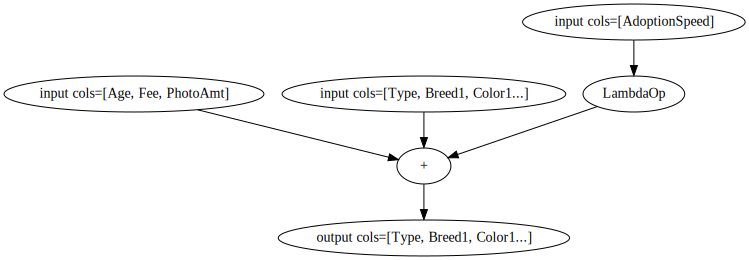

In [10]:
workflow.column_group.graph

For each one of our input datasets (or, rather, the _files_ corresponding to that dataset), we'll loop through it with a `Dataset` object, apply the preprocessing described in our `Workflow`, then export it to a new `processed` directory. Our Workflow adopts a similar API to that found with transformers in [scikit-learn](https://scikit-learn.org/stable/data_transforms.html): statistics will be calculated with a `fit` method and applied with a `transform` method.

In [11]:
for split in ["train", "valid", "test"]:
    output_path = os.path.join(data_dir, "processed", split)
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dataset = nvt.Dataset(os.path.join(data_dir, split + ".parquet"))
    if split == "train":
        shuffle = nvt.io.Shuffle.PER_WORKER
        workflow.fit(dataset)
        workflow.transform(dataset).to_parquet(
            output_path=output_path, shuffle=shuffle, out_files_per_proc=1
        )
    else:
        shuffle = False
        workflow.transform(dataset).to_parquet(
            output_path=output_path, shuffle=shuffle, out_files_per_proc=1
        )

## Feature Columns and Online Preprocessing
And that's it! Now we can proceed largely as we do in the original notebook, building the requisite TensorFlow feature columns to represent both the inputs to our network and online preprocessing transformations we would like to apply to them.

In [12]:
animal_type = tf.feature_column.categorical_column_with_vocabulary_list("Type", ["Cat", "Dog"])

In [13]:
feature_columns = []

# numeric cols
for header in ["PhotoAmt", "Fee", "Age"]:
    feature_columns.append(tf.feature_column.numeric_column(header))

In [14]:
# bucketized cols
age = tf.feature_column.numeric_column("Age")
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[1, 2, 3, 4, 5])
feature_columns.append(age_buckets)

In [15]:
# indicator_columns
indicator_column_names = [
    "Type",
    "Color1",
    "Color2",
    "Gender",
    "MaturitySize",
    "FurLength",
    "Vaccinated",
    "Sterilized",
    "Health",
]
for col_name in indicator_column_names:
    categorical_column = tf.feature_column.categorical_column_with_vocabulary_list(
        col_name, dataframe[col_name].unique().to_pandas()
    )
    indicator_column = tf.feature_column.indicator_column(categorical_column)
    feature_columns.append(indicator_column)

In [16]:
# embedding columns
breed1 = tf.feature_column.categorical_column_with_vocabulary_list(
    "Breed1", dataframe.Breed1.unique().to_pandas()
)
breed1_embedding = tf.feature_column.embedding_column(breed1, dimension=8)
feature_columns.append(breed1_embedding)

In [17]:
# crossed columns
age_type_feature = tf.feature_column.crossed_column(
    [age_buckets, animal_type], hash_bucket_size=100
)
feature_columns.append(tf.feature_column.indicator_column(age_type_feature))

Except that's still not quite it, because the actual implementation of these online transformations is really suboptimal on GPU for reasons that I go over in excruciating detail in the [_accelerating-tensorflow_](./accelerating_tensorflow.ipynb) notebook. Which is too bad, not only because feature columns are a convenient input representation, but also because if you're a seasoned TF user for tabular data, you probably already have these set up! The last thing I want to make you do is rewrite a bunch of code you've spent months getting together.

That's why NVTabular provides a utility `make_feature_column_workflow` which will read through all the feature columns you use, figure out what online preprocessing steps they apply, the recreate them with an equivalent NVTabular `Workflow` that can be mapped on to the `KerasSequenceLoader` we use to load our data in order to be applied online! It will even return a simplified set of feature columns which represent all of the outputs from that `Workflow`. These can be used to instantiate the Keras `DenseFeatures` layer or, even better, since NVTabular is now handling all the online preprocessing, you can use another utility provided by NVTabular, the `ScalarDenseFeatures` layer, to map from these tensors to a dense network input!

In [18]:
online_workflow, feature_columns = make_feature_column_workflow(feature_columns, "AdoptionSpeed")

Age


In [19]:
feature_layer = layers.DenseFeatures(feature_columns)

Now we can build the dataset-construction function from before, but instead of reading from an in-memory data frame we'll read from our exported parquet datasets (which we'll load in an online fashion). We'll then map this online workflow onto these datasets using the `online_workflow.transform()` method (which, unlike the TensorFlow `Dataset.map` function, operates in-place, just in case you try to return it).

In [20]:
# I would be remiss if I didn't note here that if you want to
# be using GPUs for tabular deep learning, you should be using
# MUCH larger batch sizes than this (think about another 10
# factors of 2). However, we'll use 32 for parity with the original
# notebook for illustrative purposes only


def make_nvt_dataset(split, shuffle=True, batch_size=32):
    train_paths = glob.glob(os.path.join(data_dir, "processed", split, "*.parquet"))
    dataset = nvt.Dataset(train_paths, engine="parquet")
    if split == "train":
        online_workflow.fit(dataset)
    ds = KerasSequenceLoader(
        online_workflow.transform(dataset),
        batch_size=batch_size,
        feature_columns=feature_columns,
        label_names=["AdoptionSpeed"],
        shuffle=shuffle,
        buffer_size=0.02,
        parts_per_chunk=1,
    )
    return ds

In [21]:
train_ds = make_nvt_dataset("train", shuffle=True)
val_ds = make_nvt_dataset("valid", shuffle=False, batch_size=2048)
test_ds = make_nvt_dataset("test", shuffle=False, batch_size=4096)

The last difference here is that since our `KerasSequenceLoader` returns a `dict` of `{tensor_name: tensor}` pairs, we can't use the `tf.keras.Sequential` object like the original notebook does. Instead, we'll just explicitly create the input tensors using our simplified feature columns then chain the layers together manually. This Keras Functional API approach is much more flexible, and enables the use of models that don't have straightforward, linear paths through them.

Note also that rather than pass `val_ds` to the `validation_data` kwarg of `model.fit`, we pass the `KerasSequenceValidater` to the `callbacks` kwarg. The reason for this is that Keras doesn't support its `Sequence` object (from which `KerasSequenceLoader` inherits) as validation data, which complicates the picture for validation datasets that can't fit into memory. This custom callback takes care of calculating online validation metrics and passing them to the model's logs to be fed to downstream callbacks like the print logger. As such, it's always good practice to put it first in your `callbacks` list if you have others that rely on validation metric information (e.g. early stopping or learning rate decay).

In [22]:
inputs = {}
for column in feature_columns:
    column = getattr(column, "categorical_column", column)
    dtype = getattr(column, "dtype", tf.int64)
    inputs[column.key] = tf.keras.Input(name=column.key, shape=(1,), dtype=dtype)

x = feature_layer(inputs)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=inputs.values(), outputs=x)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

model.fit(train_ds, callbacks=[KerasSequenceValidater(val_ds)], epochs=10)

Epoch 1/10
462/462 [==============================] - 4s 8ms/step - loss: 0.6022 - accuracy: 0.6650 - val_loss: 0.6618 - val_accuracy: 0.6733
Epoch 2/10
462/462 [==============================] - 4s 8ms/step - loss: 0.5370 - accuracy: 0.6936 - val_loss: 0.6032 - val_accuracy: 0.6887
Epoch 3/10
462/462 [==============================] - 3s 7ms/step - loss: 0.5280 - accuracy: 0.6992 - val_loss: 0.6018 - val_accuracy: 0.6990
Epoch 4/10
462/462 [==============================] - 3s 7ms/step - loss: 0.5263 - accuracy: 0.7010 - val_loss: 0.6051 - val_accuracy: 0.7032
Epoch 5/10
462/462 [==============================] - 3s 7ms/step - loss: 0.5230 - accuracy: 0.7018 - val_loss: 0.5994 - val_accuracy: 0.6999
Epoch 6/10
462/462 [==============================] - 4s 8ms/step - loss: 0.5199 - accuracy: 0.7069 - val_loss: 0.5971 - val_accuracy: 0.7045
Epoch 7/10
462/462 [==============================] - 4s 8ms/step - loss: 0.5167 - accuracy: 0.7085 - val_loss: 0.5993 - val_accuracy: 0.7103
Epoch 

In [23]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

2/2 [==============================] - 0s 215ms/step - loss: 0.5194 - accuracy: 0.7097
Accuracy 0.7097053527832031


So there it is, end-to-end GPU-accelerated deep learning model development in TensorFlow with the addition of just a couple lines of code. And the best part, as we discussed above, is that this will scale to gigantic datasets and complex models with almost _no_ changes! Fast, simple, and scalable.

For more examples of how to do this, take a look at the [_accelerating-tensorflow_](./accelerating-tensorflow.ipynb) notebook for training and the [_criteo-example_](../criteo-example.ipynb) notebook for data preprocessing.